In [101]:
!pip install -U --pre tensorflow=="2.*"

In [97]:
!pip install pycocotools

In [98]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models


In [99]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [100]:
%%bash 
cd models/research
pip install 

ERROR: You must give at least one requirement to install (see "pip help install")


In [143]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [102]:
%cd models/research
dir

/content/models/research


<function dir>

In [103]:
pip install tf_slim

In [ ]:
pip install tensorflow-object-detection-api

In [121]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [122]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

In [123]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [137]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('/content/1.jpg'),
 PosixPath('/content/2.jpg'),
 PosixPath('/content/3.jpg')]

In [138]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [139]:
print(detection_model.inputs)
detection_model.output_dtypes

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [140]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [141]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=9)

  display(Image.fromarray(image_np))

In [ ]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)

In [ ]:
# TechVidvan Object detection of similar color

import cv2
import numpy as np
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/1.jpg")

#define kernel size  
kernel = np.ones((7,7),np.uint8)


# convert to hsv colorspace 
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# lower bound and upper bound for Green color 
# lower_bound = np.array([50, 20, 20])     
# upper_bound = np.array([100, 255, 255])

# lower bound and upper bound for Yellow color
sensitivity = 15 
lower_bound = np.array([0,0,(255-sensitivity)])     
upper_bound = np.array([255,sensitivity,255])


# find the colors within the boundaries
mask = cv2.inRange(hsv, lower_bound, upper_bound)


# Remove unnecessary noise from mask

mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)



# Segment only the detected region

segmented_img = cv2.bitwise_and(img, img, mask=mask)

# Find contours from the mask

contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contour on segmented image
 
# output = cv2.drawContours(segmented_img, contours, -1, (0, 0, 255), 3)


# Draw contour on original image

output = cv2.drawContours(img, contours, -1, (0, 0, 255), 3)

# Showing the output

# cv2.imshow("Image", img)
cv2_imshow(output)

cv2.waitKey(0)
cv2.destroyAllWindows()



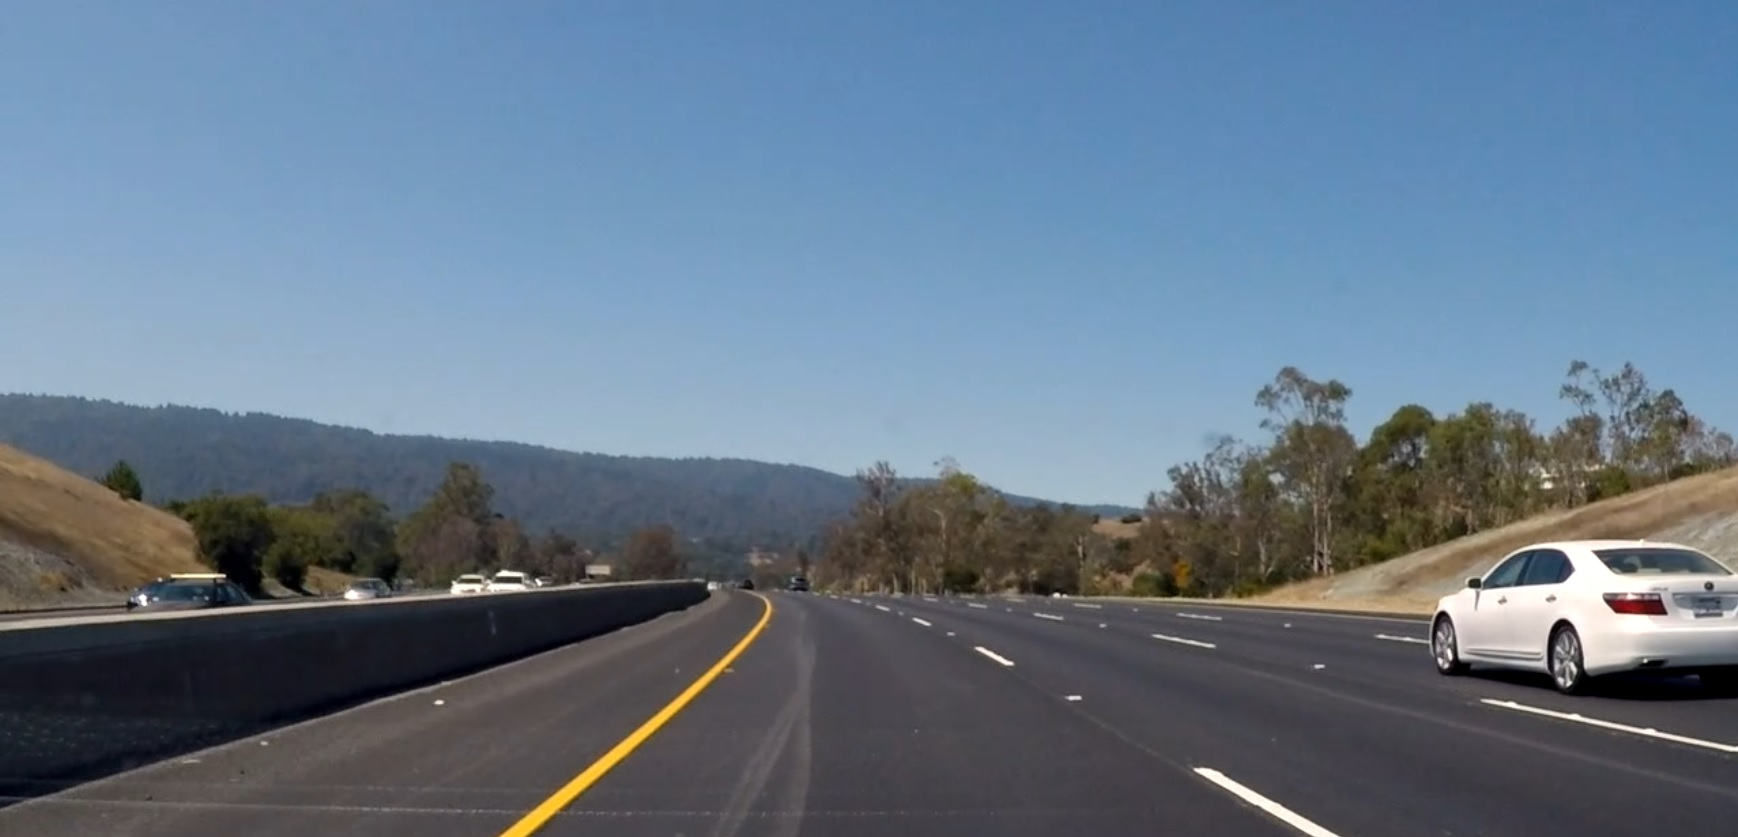

In [8]:
import cv2
import numpy as np
import pandas as pd
import argparse
from google.colab.patches import cv2_imshow

img_path = ("/content/1.jpg")

#Reading the image with opencv
img = cv2.imread(img_path)

#declaring global variables (are used later on)
clicked = False
r = g = b = xpos = ypos = 0

#Reading csv file with pandas and giving names to each column
index=["color","color_name","hex","R","G","B"]
csv = pd.read_csv('colors.csv', names=index, header=None)

#function to calculate minimum distance from all colors and get the most matching color
def getColorName(R,G,B):
    minimum = 10000
    for i in range(len(csv)):
        d = abs(R- int(csv.loc[i,"R"])) + abs(G- int(csv.loc[i,"G"]))+ abs(B- int(csv.loc[i,"B"]))
        if(d<=minimum):
            minimum = d
            cname = csv.loc[i,"color_name"]
    return cname

#function to get x,y coordinates of mouse double click
y=400
x=300
b,g,r = img[y,x]
b = int(b)
g = int(g)
r = int(r)
       



cv2_imshow(img)
text = getColorName(r,g,b) + ' R='+ str(r) +  ' G='+ str(g) +  ' B='+ str(b)
        
        #cv2.putText(img,text,start,font(0-7),fontScale,color,thickness,lineType )
cv2.putText(img, text,(50,50),2,0.8,(255,255,255),2,cv2.LINE_AA)

        #For very light colours we will display text in black colour
if(r+g+b>=600):
    cv2.putText(img, text,(50,50),2,0.8,(0,0,0),2,cv2.LINE_AA)
    
cv2.destroyAllWindows()
